In [96]:
import os
import glob

import tqdm
import numpy as np
import scipy.ndimage
import scipy.misc
import sklearn.metrics

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from collections import defaultdict

import random

import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D

import argparse
IMG_SIZE = (128,128)

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load data as numpy array
# for image_path in tqdm.tqdm(list(glob.glob('/content/drive/My Drive/cs 229/train_another/**/*.jpeg'))):
#     image = Image.open(image_path)
#     image_pixels = np.array(image)
#     image_basepath, _ = os.path.splitext(image_path)
#     np.savez(image_basepath+'.npz', pixels=image_pixels)

100%|██████████| 10000/10000 [50:52<00:00,  3.28it/s]


In [98]:
class DataEncoder():
    def __init__(self, all_damage_labels):
        self.all_damage_labels = all_damage_labels

    def one_hot_index(self, damage_label):
        return self.all_damage_labels.index(damage_label)

    def one_hot_decode(self, predicted_labels):
        return dict(zip(self.all_damage_labels, predicted_labels))

    def one_hot_encode(self, damage_label):
        one_hot_encoded_vector = np.zeros(len(self.all_damage_labels))
        idx = self.one_hot_index(damage_label)
        one_hot_encoded_vector[idx] = 1
        return one_hot_encoded_vector

In [99]:
image_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=0.15,
    zoom_range=0.15,
    channel_shift_range=1,
    horizontal_flip=True,
    vertical_flip=False,
)

In [100]:
class DataGenerator():
    def __init__(self, data_path):
        self.data_path = data_path
        self.partition2damage2npz = {
            'train': defaultdict(list),
            'validation': defaultdict(list),
            'test': defaultdict(list),
        }
        self.all_damage_labels = set()
        npz_file_listing = list(glob.glob(os.path.join(data_path, '**/*.npz')))
        for npz_path in npz_file_listing:
            damage = os.path.basename(os.path.dirname(npz_path))
            self.all_damage_labels.add(damage)
            if hash(npz_path) % 10 < 7:
                partition = 'train'
            elif 7 <= hash(npz_path) % 10 < 9:
                partition = 'validation'
            elif 9 == hash(npz_path) % 10:
                partition = 'test'
            else:
                raise Exception("partition not assigned")
            self.partition2damage2npz[partition][damage].append(npz_path)
        self.encoder = DataEncoder(sorted(list(self.all_damage_labels)))

    def _pair_generator(self, partition, augmented=True):
        partition_data = self.partition2damage2npz[partition].items()
        while True:
            for damage, npzs in partition_data:
                npz_path = random.choice(npzs)
                pixels = np.load(npz_path)['pixels']
                one_hot_encoded_labels = self.encoder.one_hot_encode(damage)
                if augmented:
                    augmented_pixels = next(
                        image_datagen.flow(np.array([pixels]))
                    )[0].astype(np.uint8)
                    yield augmented_pixels, one_hot_encoded_labels
                else:
                    yield pixels, one_hot_encoded_labels


    def batch_generator(self, partition, batch_size, augmented=True):
        while True:
            data_gen = self._pair_generator(partition, augmented)
            pixels_batch, one_hot_damage_batch = zip(
                *[next(data_gen) for _ in range(batch_size)]
            )
            pixels_batch = np.array(pixels_batch)
            one_hot_damage_batch = np.array(one_hot_damage_batch)
            yield pixels_batch, one_hot_damage_batch

In [101]:
IN_SHAPE = (*IMG_SIZE, 3)

def get_model(all_damage_labels):
    pretrained_model = VGG19(
                include_top=False,
                input_shape=IN_SHAPE,
                weights='imagenet'
            )
    
    if pretrained_model.output.shape.ndims > 2:
        output = Flatten()(pretrained_model.output)
    else:
        output = pretrained_model.output
        
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(128, activation='relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(len(all_damage_labels), activation='softmax')(output)
    model = Model(pretrained_model.input, output)
    for layer in pretrained_model.layers:
        layer.trainable = False
    model.summary(line_length=200)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [120]:
BATCH_SIZE = 64

# Think we need a TensorBoard install for this part of the code
# tensorboard_callback = keras.callbacks.TensorBoard(
#         log_dir=args.tensorboard_directory,
#         histogram_freq=0,
#         write_graph=True,
#         write_images=False
#     )

# Think this is for saving the model
# save_model_callback = keras.callbacks.ModelCheckpoint( 
#     os.path.join(args.weight_directory, 'weights.{epoch:02d}.h5'),
#     verbose=3,
#     save_best_only=False,
#     save_weights_only=False,
#     mode='auto',
#     period=1
# )

data_dir = '/content/drive/My Drive/cs 229/train_another'

data_generator = DataGenerator(data_dir)

model = get_model(data_generator.encoder.all_damage_labels
)

model.fit_generator(
    data_generator.batch_generator('train', batch_size=BATCH_SIZE),
    steps_per_epoch=200,
    epochs=5,
    validation_data=data_generator.batch_generator(
        'validation',
        batch_size=BATCH_SIZE,
        augmented=False
    ),
    validation_steps=10
#     callbacks=[save_model_callback, tensorboard_callback], #<--Think this is for the above callbacks
#    workers=4 <- causes it to break
)

Model: "functional_11"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_6 (InputLayer)                                                                      [(None, 128, 128, 3)]                                                           0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                                                     (None, 128, 128, 64)                                                            179

In [121]:
test_paths = data_generator.partition2damage2npz['test']
print(len(test_paths['damage']) + len(test_paths['no_damage']))

1038


In [122]:
train_paths = data_generator.partition2damage2npz['train']
val_paths = data_generator.partition2damage2npz['validation']
print(len(train_paths['damage']) + len(train_paths['no_damage']))
print(len(val_paths['damage']) + len(val_paths['no_damage']))

6923
2039


In [123]:
idx = 0
damage_image_pixels = np.zeros((523, 128, 128, 3))
for pixels_path in tqdm.tqdm(list(test_paths['damage'])):
    damage_image_pixels[idx, :,:,:] = np.load(pixels_path)['pixels']
    idx +=1

idx = 0
no_damage_image_pixels = np.zeros((515, 128, 128, 3))
for pixels_path in tqdm.tqdm(list(test_paths['no_damage'])):
    no_damage_image_pixels[idx, :,:,:] = np.load(pixels_path)['pixels']
    idx +=1

100%|██████████| 515/515 [00:00<00:00, 649.13it/s]


In [124]:
damage_predicted_labels = model.predict(damage_image_pixels)
no_damage_predicted_labels = model.predict(no_damage_image_pixels)

In [127]:
correct_lab_damage = np.sum(damage_predicted_labels[:,0] > damage_predicted_labels[:,1])
correct_lab_no_damage = np.sum(no_damage_predicted_labels[:,0] < no_damage_predicted_labels[:,1])

print((correct_lab_damage + correct_lab_no_damage) / 1038)

0.9335260115606936


In [138]:
damage_predicted_labels.shape

(523, 2)

In [140]:
damage_pred = damage_predicted_labels[:,0] < damage_predicted_labels[:,1]
no_damage_pred = no_damage_predicted_labels[:,0] < no_damage_predicted_labels[:,1]

Text(0.5, 1.0, 'Confusion Matrix for Test Images')

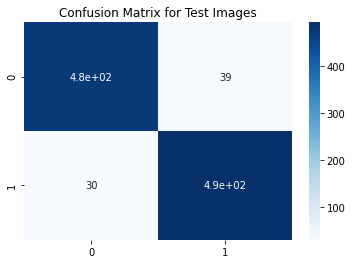

In [137]:
y_true = np.concatenate((np.zeros(no_damage_image_pixels.shape[0]), np.ones(damage_image_pixels.shape[0])))
y_pred = np.concatenate((damage_pred, no_damage_pred))
confusion_mat = sklearn.metrics.confusion_matrix(y_true, y_pred)
sn.heatmap(confusion_mat, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Test Images")

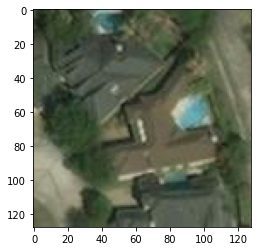

In [110]:
plt.imshow(no_damage_image_pixels[1,:,:,:] / 255)